## Attempt at CSI HAR using a simple CNN

In [1]:
!pip install lime > /dev/null
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp /content/drive/MyDrive/CSI/dataset/rCSI-3.mat .
!cp /content/drive/MyDrive/CSI/dataset/rCSI-4.mat .

In [3]:
!sha256sum *.mat

64c676c209fa3e8818e371e08774caf6e6f9d4657e76001ec56f1ca025b65152  rCSI-3.mat
59663fc32cb6170f14a3a44cf82fda19a5c39ac178fd8320ba2557f8f7d2326e  rCSI-4.mat


In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras import layers, models


class CSIScaler(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        self._mean = None

    def fit(self, *_, **__):
        return self

    def transform(self, X):
        X = np.swapaxes(X, 1, 2)

        n_samples, t_max, *_ = X.shape

        min_vec = np.min(X, axis=(0, 1))
        min_vec = np.expand_dims(min_vec, axis=(0, 1))
        X -= np.tile(min_vec, (n_samples, t_max, 1))
        max_vec = np.max(X, axis=(0, 1))
        max_vec = np.expand_dims(max_vec, axis=(0, 1))
        X /= np.tile(max_vec, (n_samples, t_max, 1))

        X = np.swapaxes(X, 1, 2)

        return X


def load_dataset(infile):
    mat = scipy.io.loadmat(infile)
    X = mat["csi"].T
    nsamples = mat["nsamples"].flatten()
    dim = mat["dim"].flatten()
    classnames = list(map(lambda s: s.strip().title(), mat["classnames"]))
    y = []
    for i in range(len(classnames)):
        y += [i] * nsamples[i]
    y = np.array(y)
    return X, y, nsamples, classnames, dim


def create_model():
    model = models.Sequential()

    model.add(
        layers.Conv2D(
            8,
            (3, 4),
            kernel_initializer="he_normal",
            dilation_rate=(1, 1),
            activation="relu",
            input_shape=(dim[0], dim[1], 1),
        )
    )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    model.add(
        layers.Conv2D(
            16,
            (3, 4),
            kernel_initializer="he_normal",
            dilation_rate=(1, 1),
            activation="relu",
        )
    )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    model.add(
        layers.Conv2D(
            32,
            (5, 6),
            kernel_initializer="he_normal",
            dilation_rate=(2, 2),
            activation="relu",
        )
    )
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(3, kernel_initializer="he_normal"))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 52, 253, 8)        104       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 126, 8)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 26, 126, 8)       32        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 123, 16)       1552      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 61, 16)       0         
 2D)                                                             
                                                      

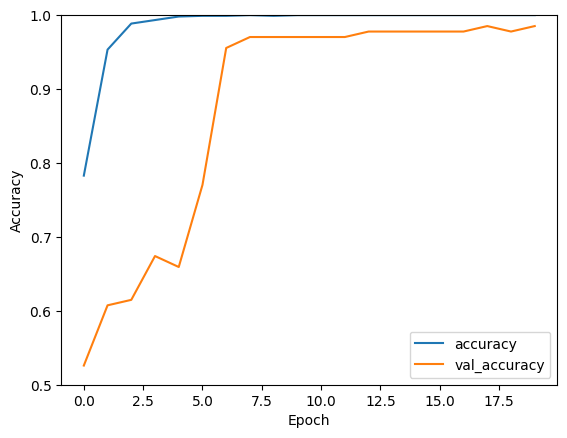

In [6]:
X, y, nsamples, classnames, dim = load_dataset("rCSI-3.mat")

X = X.reshape((X.shape[0], *dim))
# X = CSIScaler().fit_transform(X)

# Approx split - 70% (train) + 20% (test) + 10% (validation)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.7, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(
    X_rem, y_rem, train_size=0.7, stratify=y_rem
)

model = create_model()
model.summary()

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

y_test_preds = model.predict(X_test)
y_test_preds = np.argmax(y_test_preds, axis=1)

print("\nTest Accuracy : {}".format(accuracy_score(y_test, y_test_preds)))
print("\nConfusion Matrix : ")
print(confusion_matrix(y_test, y_test_preds))
print("\nClassification Report :")
print(classification_report(y_test, y_test_preds, target_names=classnames))

plt.figure()
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")
plt.show()

In [7]:
model.save("csi-sense.h5")

In [8]:
X, y, _, classnames, dim = load_dataset("rCSI-4.mat")
X = X.reshape(X.shape[0], *dim)
X = CSIScaler().fit_transform(X)

y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=1)

print(f"\n> Test Accuracy: {accuracy_score(y, y_pred)*100:.4f}%")
print("\n> Confusion Matrix: ")
print(confusion_matrix(y, y_pred))
print("\n> Classification Report :")
print(classification_report(y, y_pred, target_names=classnames))

12/12 [==============================] - 0s 10ms/step

> Test Accuracy: 33.3333%

> Confusion Matrix: 
[[  0 120   0]
 [  0 120   0]
 [  0 120   0]]

> Classification Report :
              precision    recall  f1-score   support

       Empty       0.00      0.00      0.00       120
        Walk       0.33      1.00      0.50       120
        Jump       0.00      0.00      0.00       120

    accuracy                           0.33       360
   macro avg       0.11      0.33      0.17       360
weighted avg       0.11      0.33      0.17       360



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Interpret learning using LIME

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

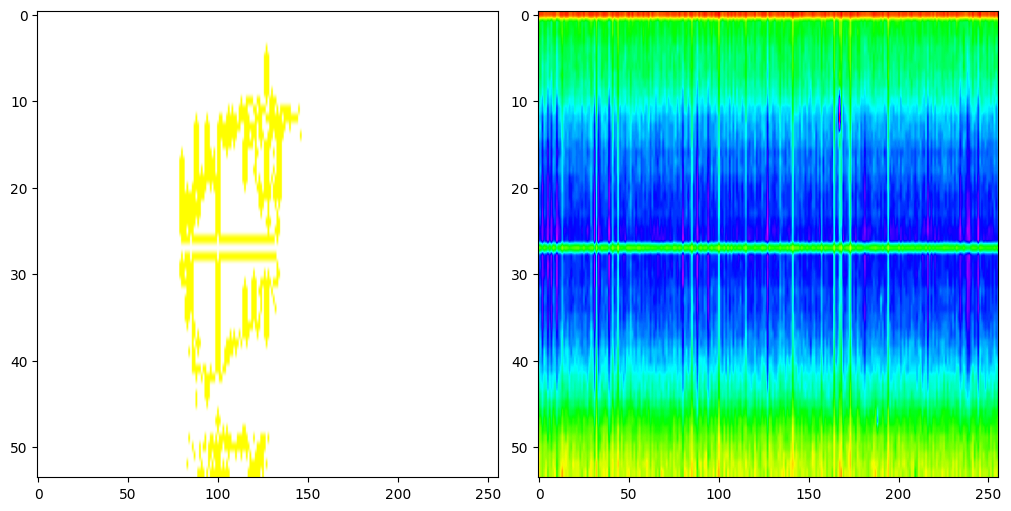

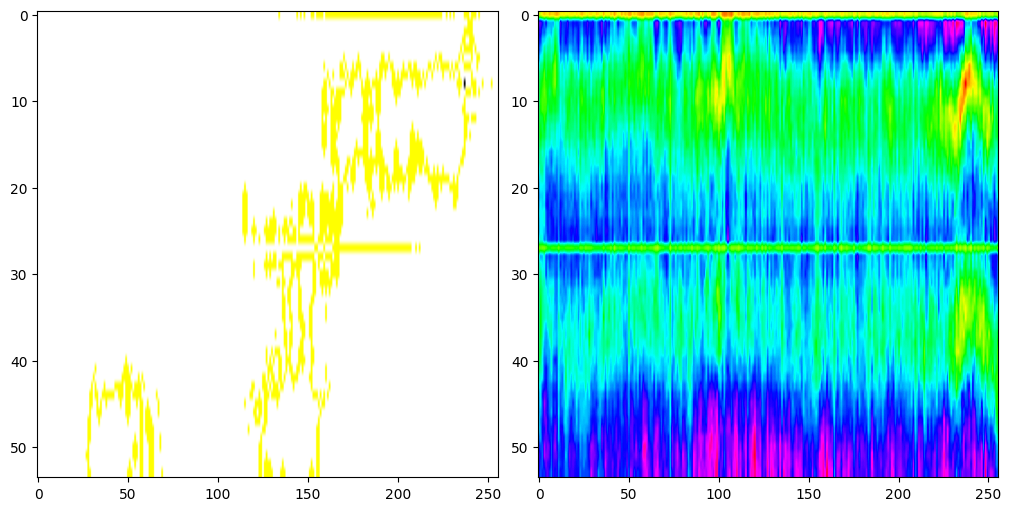

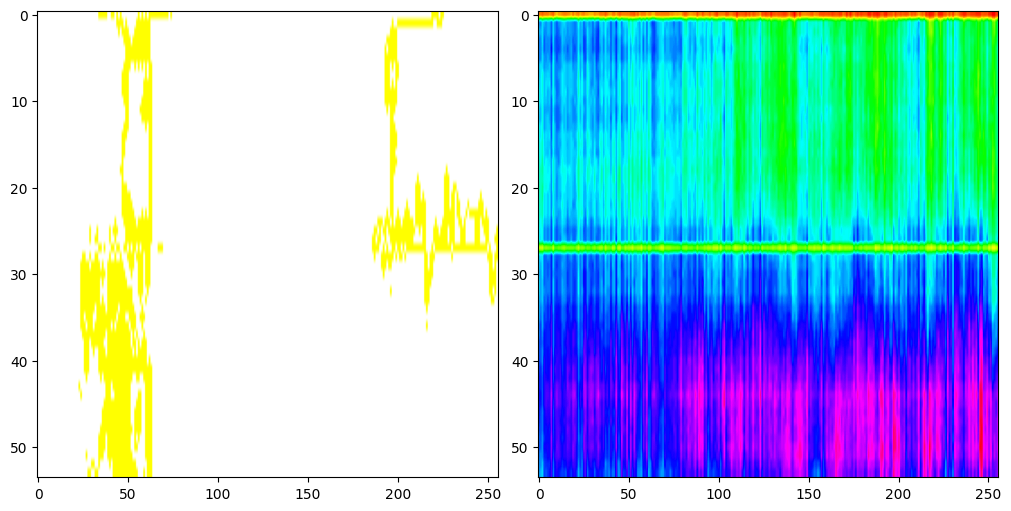

In [9]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray, gray2rgb


def prediction_for_lime(imgs):
    imgs_recons = rgb2gray(imgs)
    return model.predict(imgs_recons, verbose=0)


explainer = lime_image.LimeImageExplainer()

classwise_results = []

for i in range(len(classnames)):
    X_class = X_test[y_test == i]
    y_class = y_test[y_test == i]

    idx = np.random.randint(0, y_class.size)

    classwise_results.append(
        (
            explainer.explain_instance(gray2rgb(X_class[idx]), prediction_for_lime),
            idx,
            i,
        )
    )

for explanation, idx, cid in classwise_results:
    image, mask = explanation.get_image_and_mask(cid, num_features=dim[0] * dim[1])

    image = rgb2gray(image)

    plt.figure(figsize=(10, 5), constrained_layout=True)
    plt.subplot(1, 2, 1)
    plt.imshow(mark_boundaries(image, mask), aspect="auto")
    plt.subplot(1, 2, 2)
    plt.imshow(image, aspect="auto", cmap="hsv")
    plt.show()